# Practical Exercise - Real-life example

This is a Practical Exercise for the Real-life example present in the "The Data Science Course: Complete Data Science Bootcamp", a data science course created by 365 Careers and distributed via Udemy.

This exercise and the database are presented on the lesson: "Section 35: Advanced Statistical Methods - Practical Example Linear Regression".

You can access the complete course using the following link: https://www.udemy.com/course/the-data-science-course-complete-data-science-bootcamp/

## Accompanied Model

First of all, I'll recreate the model as presented in the lessons of the course. After that, I'll try to create my own model, using different variables, transformations and strategies.

### Database preprocessing

#### Importing the libraries

In [37]:
import pandas as pd
import numpy as np
import scipy
import math
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
#import statsmodels.api as sm
#import sklearn
#from scipy.stats import f

#### Importing the database

In [2]:
df = pd.read_csv(r"../1.04. Real-life example.csv")

In [3]:
df_full = df.copy()

#### Null entries identification

In [4]:
df.isnull().sum()

Brand             0
Price           172
Body              0
Mileage           0
EngineV         150
Engine Type       0
Registration      0
Year              0
Model             0
dtype: int64

In [5]:
df = df.dropna(axis = 0)

Since there are null or NAN values in the columns Price and EngineV, we need to apply some kind of process to adjust these values. Following the recommendations presented in the course, I've removed these values.

#### Removing outliers

<b> Author: </b>As presented in the course and in the graphs below, the following independent variables present many outliers, which will reduce the accuracy of the model:

- Price: Superior outliers
- Mileage: Superior outliers
- Year: Inferior outliers

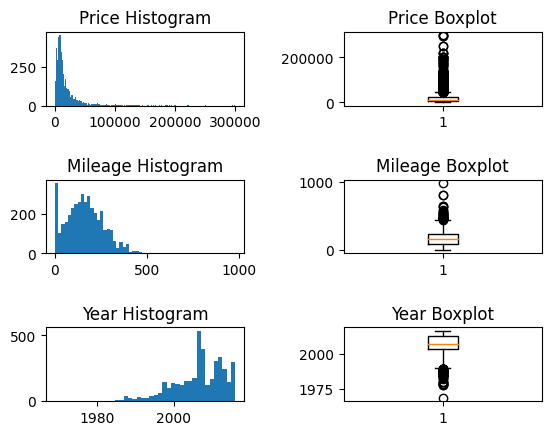

In [6]:
fig, axs = plt.subplots(3, 2, sharex = False)
#fig.tight_layout()
axs[0, 0].hist(df["Price"], bins = "auto")
axs[0, 0].set_title("Price Histogram")
axs[0, 1].boxplot(df["Price"])
axs[0, 1].set_title("Price Boxplot")
axs[1, 0].hist(df["Mileage"], bins = "auto")
axs[1, 0].set_title("Mileage Histogram")
axs[1, 1].boxplot(df["Mileage"])
axs[1, 1].set_title("Mileage Boxplot")
axs[2, 0].hist(df["Year"], bins = "auto")
axs[2, 0].set_title("Year Histogram")
axs[2, 1].boxplot(df["Year"])
axs[2, 1].set_title("Year Boxplot")

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=1)

plt.show()

<b> Author: </b>Following the course instructions, I removed the 1% outliers from top or bottom, accordingly with the variable. The results can be seen below:

In [7]:
df = df[df["Price"] < df["Price"].quantile(0.99)]
df = df[df["Mileage"] < df["Mileage"].quantile(0.99)]
df = df[df["Year"] > df["Year"].quantile(0.01)]

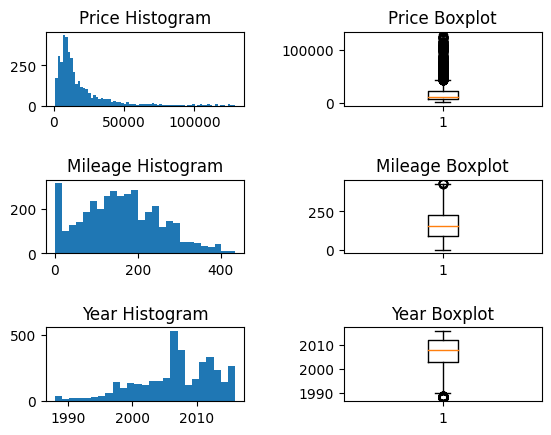

In [8]:
fig, axs = plt.subplots(3, 2, sharex = False)
#fig.tight_layout()
axs[0, 0].hist(df["Price"], bins = "auto")
axs[0, 0].set_title("Price Histogram")
axs[0, 1].boxplot(df["Price"])
axs[0, 1].set_title("Price Boxplot")
axs[1, 0].hist(df["Mileage"], bins = "auto")
axs[1, 0].set_title("Mileage Histogram")
axs[1, 1].boxplot(df["Mileage"])
axs[1, 1].set_title("Mileage Boxplot")
axs[2, 0].hist(df["Year"], bins = "auto")
axs[2, 0].set_title("Year Histogram")
axs[2, 1].boxplot(df["Year"])
axs[2, 1].set_title("Year Boxplot")

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=1)

plt.show()

<b> Author: </b>Much better! Later, I'll try removing other percentages of outliers.

<b> Author: </b>Another outlier that is biasing our data is the EngineV. This can be seen in the graphs below:

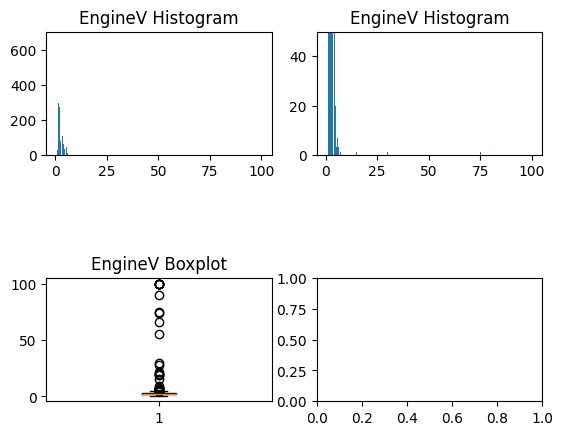

In [9]:
fig, axs = plt.subplots(2, 2)

axs[0, 0].hist(df["EngineV"], bins = "auto")
axs[0, 0].set_title("EngineV Histogram")
axs[0, 1].hist(df["EngineV"], bins = "auto")
axs[0, 1].set_ylim([0,50])
axs[0, 1].set_title("EngineV Histogram")
axs[1, 0].boxplot(df["EngineV"])
axs[1, 0].set_title("EngineV Boxplot")

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)

plt.show()

<b> Author:</b> According to the course and wikipedia, the volume of engines allowed by regulations is usually between 0.6 and 6.5. For this reason, all the values above 6.5 have been removed, which are just 23 observations, as follows:

In [10]:
print(df.shape)

df = df[df["EngineV"] < 6.5]

print(df.shape)

(3890, 9)
(3867, 9)


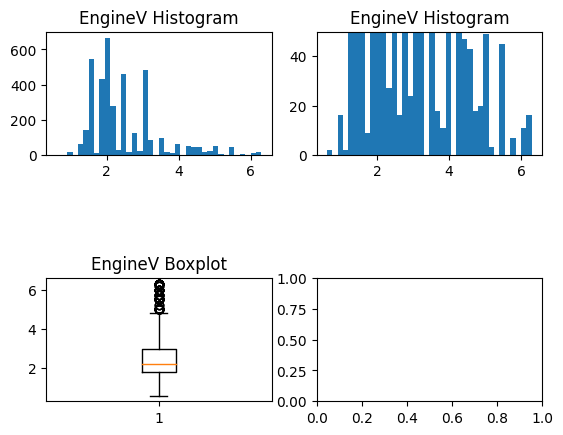

In [11]:
fig, axs = plt.subplots(2, 2)

axs[0, 0].hist(df["EngineV"], bins = "auto")
axs[0, 0].set_title("EngineV Histogram")
axs[0, 1].hist(df["EngineV"], bins = "auto")
axs[0, 1].set_ylim([0,50])
axs[0, 1].set_title("EngineV Histogram")
axs[1, 0].boxplot(df["EngineV"])
axs[1, 0].set_title("EngineV Boxplot")

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1)

plt.show()

#### Categorical variables distribution

<b>Author:</b> To acquire a good model, it is important to verify if there are categorical variables that have a value too predominant or too spase in the database. Using the table below, we can see that the variable Registration presents 90% of values equal to yes. On the other hand, the variable Model has too many different values, with a mode with only 4% of ocurrence, which can easily make our model overfit:

In [12]:
df_categoricals = pd.DataFrame()
list_mode_count = []
list_mode_percent = []
list_columns = []
list_modes = []

for categoric_column in ["Brand", "Body", "Engine Type", "Registration", "Model"]:
    column_mode = df[categoric_column].mode()[0]
    #print(df[df[categoric_column] == "BMW"])
    list_mode_count.append(df[df[categoric_column] == column_mode].shape[0])
    list_mode_percent.append(df[df[categoric_column] == column_mode].shape[0] / df.shape[0])
    list_columns.append(categoric_column)
    list_modes.append(column_mode)

df_categoricals["Column"] = list_columns
df_categoricals["Mode"] = list_modes
df_categoricals["Count Mode"] = list_mode_count
df_categoricals["Percent Mode"] = list_mode_percent

In [13]:
df_categoricals

,Column,Mode,Count Mode,Percent Mode
0,Brand,Volkswagen,848,0.219291
1,Body,sedan,1467,0.379364
2,Engine Type,Diesel,1807,0.467287
3,Registration,yes,3505,0.906387
4,Model,E-Class,181,0.046806


<b>Author:</b> Analyzing this variable Registration in the detail, we can see that the value no has a very high chance to be related to a car with low price. Since the value has so many ocurrences, it is important to remove it to not create a non-generalization of the model.

In [14]:
a = df[df["Registration"] == "yes"]["Price"]
b = df[df["Registration"] == "no"]["Price"]

In [15]:
bins = np.histogram(np.hstack((a,b)), bins=40)[1]

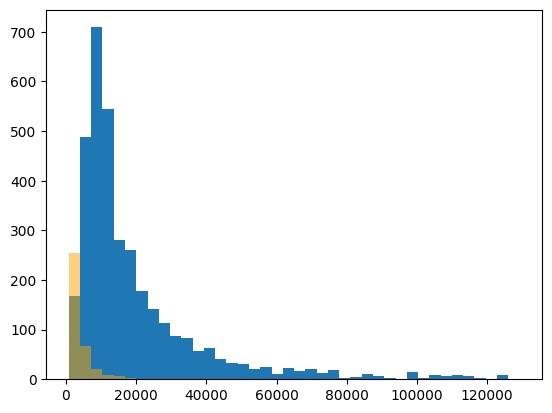

In [16]:
plt.hist(df[df["Registration"] == "yes"]["Price"], bins = bins)
plt.hist(df[df["Registration"] == "no"]["Price"], bins = bins, color = "orange", alpha = 0.5)
plt.show()

<b>Author:</b> About the variable model, since it is too sparse in the database, we are going to remove it too.

In [17]:
df = df.drop(["Model", "Registration"], axis = 1)

#### Creating dummies

<b>Author:</b> To use the categorical variables in a machine learning model, it is important to transform them into numerical variables. To make this, we use the Get Dummies method of the pandas, which create binary columns for each categorical value, as below:

In [18]:
df = pd.get_dummies(df, drop_first = True)

## Model selection

#### Verifying the Linear Regression assumptions

##### Linearity

<b> Author: </b>As shown below, the quantitative variables Year and Mileage are non-linear. To solve this, we are going to use the log of the dependente variable Price, instead of using the value in dollars.

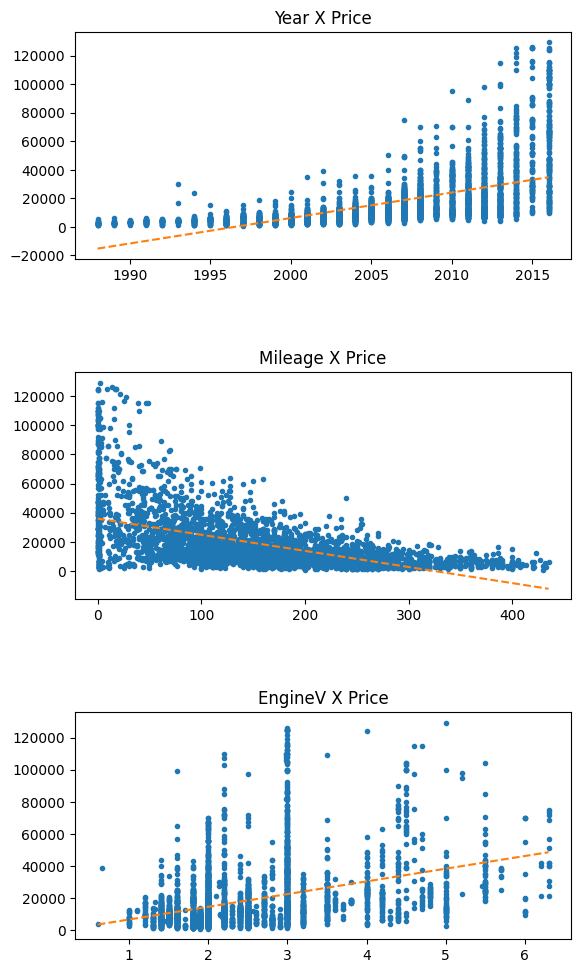

In [19]:
fig, axs = plt.subplots(3, sharex = False)
plot_number = 0

for numeric_column in ["Year", "Mileage", "EngineV"]:
    polyfit = np.polyfit(df[numeric_column], df["Price"], 1)
    poly_1d = np.poly1d(polyfit)
    linspace = np.linspace(min(df[numeric_column]), max(df[numeric_column]), df["Price"].shape[0])
    axs[plot_number].plot(df[numeric_column], df["Price"], ".", linspace, poly_1d(linspace), "--")
    axs[plot_number].set_title(str(numeric_column) + " X Price")
    plot_number += 1

plt.subplots_adjust(left=None, bottom=None, right=None, top=2, wspace=None, hspace=0.5)
    
plt.show()

In [20]:
df["log_price"] = df["Price"].apply(np.log)

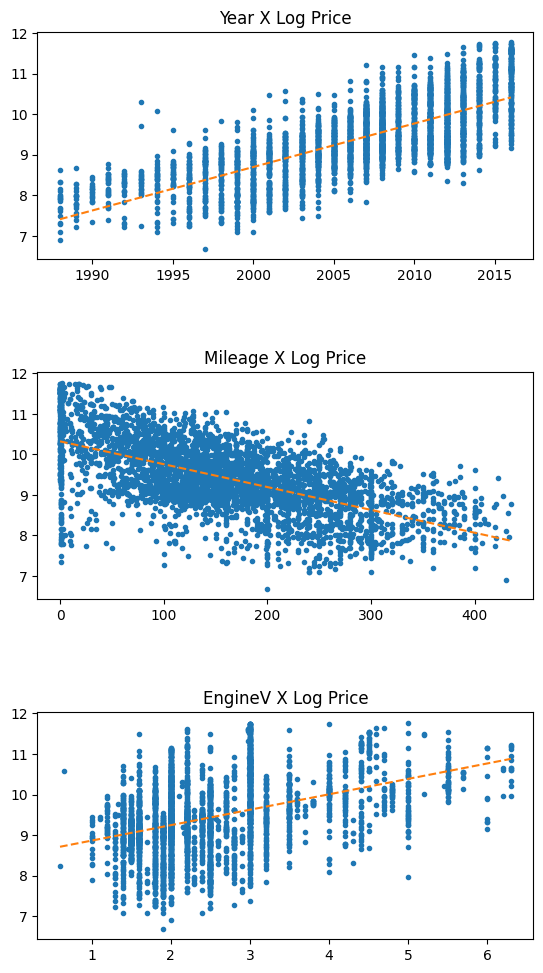

In [21]:
fig, axs = plt.subplots(3, sharex = False)
plot_number = 0

for numeric_column in ["Year", "Mileage", "EngineV"]:
    polyfit = np.polyfit(df[numeric_column], df["log_price"], 1)
    poly_1d = np.poly1d(polyfit)
    linspace = np.linspace(min(df[numeric_column]), max(df[numeric_column]), df["log_price"].shape[0])
    axs[plot_number].plot(df[numeric_column], df["log_price"], ".", linspace, poly_1d(linspace), "--")    
    axs[plot_number].set_title(str(numeric_column) + " X Log Price")
    plot_number += 1

plt.subplots_adjust(left=None, bottom=None, right=None, top=2, wspace=None, hspace=0.5)
    
plt.show()

##### No endogeneity

<b> Author:</b> This assumption is easier to analyze after our first execution of the model and will be reviewed after. Nevertheless, we do not expect to find a correlation between the residuals and the independent variables;

##### No autocorrelation

<b> Author:</b> Since the observations are related to different persons and different vehicles, we do not expect to identify an autocorrelation in the data;

##### Normality, Zero Mean and Homoscedasticity

<b> Author:</b> Since the sample size is big (greater than 30), by using the Central Limit Theorem we can assure that the residuals will have a normal distribution. Using the Ordinary Least Squares and its intercept, we already assure that the residuals will have a distribution around the mean zero. Regarding Homoscedasticity, we can see by the graphs below that we cannot find any relevant Heteroscedasticity in the data;

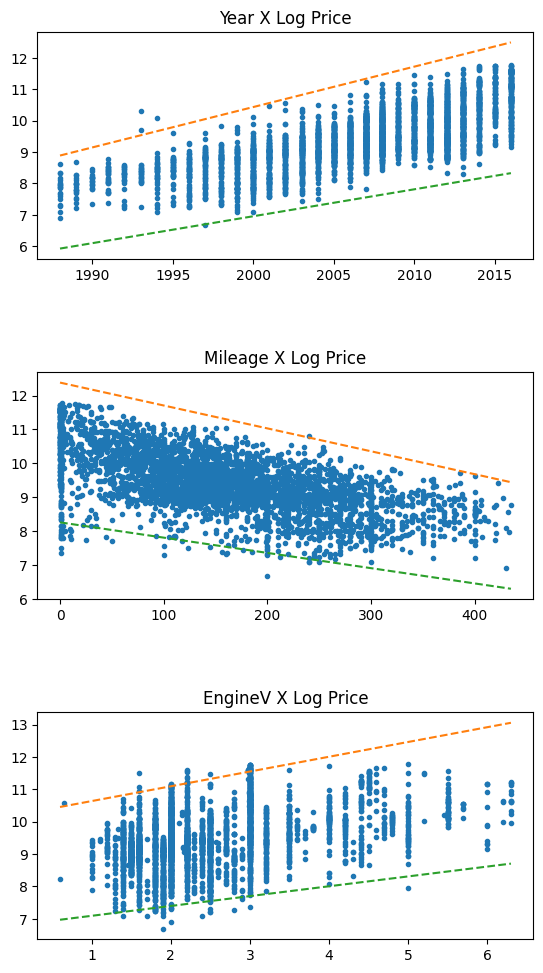

In [22]:
fig, axs = plt.subplots(3)
plot_number = 0

for numeric_column in ["Year", "Mileage", "EngineV"]:
    polyfit = np.polyfit(df[numeric_column], df["log_price"], 1)
    poly_1d = np.poly1d(polyfit)
    linspace = np.linspace(min(df[numeric_column]), max(df[numeric_column]), df["log_price"].shape[0])
    axs[plot_number].plot(df[numeric_column], df["log_price"], ".", linspace, poly_1d(linspace)*1.2, "--", linspace, poly_1d(linspace)*0.8, "--")
    axs[plot_number].set_title(str(numeric_column) + " X Log Price")
    plot_number += 1

plt.subplots_adjust(left=None, bottom=None, right=None, top=2, wspace=None, hspace=0.5)
    
plt.show()

##### No multicollinearity

<b> Author:</b> To test this assumption, we are going to use the variance_inflation_factor(VIF) method of the statsmodels package. Variables with a VIF above 5 are too collinears with the others and, for this reason, are very good candidates to be removed from the model.

In [23]:
variables = df[["Year", "Mileage", "EngineV"]]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["Features"] = variables.columns
print(vif)

         VIF Features
0  10.354854     Year
1   3.791584  Mileage
2   7.662068  EngineV


<b> Author:</b> Since the variable Year is too collinear with the others, we are going to remove it from the model and reprocess the VIF, to verifiy if there is still collinearity:

In [24]:
variables = df[["Mileage", "EngineV"]]
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["Features"] = variables.columns
print(vif)

        VIF Features
0  2.805214  Mileage
1  2.805214  EngineV


## Model processing

<b>Author:</b> Now that we've already prepared the data, we can create our first model. Since we created the variable log_price, we can drop the variable Price, and sort the database:

In [29]:
df_preprocessed = df[['log_price', 'Mileage', 'EngineV', 'Year', 'Brand_BMW',
       'Brand_Mercedes-Benz', 'Brand_Mitsubishi', 'Brand_Renault',
       'Brand_Toyota', 'Brand_Volkswagen', 'Body_hatch', 'Body_other',
       'Body_sedan', 'Body_vagon', 'Body_van', 'Engine Type_Gas',
       'Engine Type_Other', 'Engine Type_Petrol']].copy()

<b>Author:</b> Now, we must segregate our targets and inputs, and then scale them:

In [30]:
targets = df_preprocessed["log_price"]
inputs = df_preprocessed.drop("log_price", axis = 1)

In [34]:
scaler = StandardScaler()

In [35]:
scaler.fit(inputs)
inputs_scaled = scaler.transform(inputs)

In [38]:
x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size = 0.2, random_state = 365)

In [40]:
reg = LinearRegression()
reg.fit(x_train, y_train)
print(reg.score(x_train, y_train))
print(reg.score(x_test, y_test))

0.8162265875285557
0.8130620684235472


In [41]:
y_hat = reg.predict(x_train)

In [42]:
y_test_hat = reg.predict(x_test)

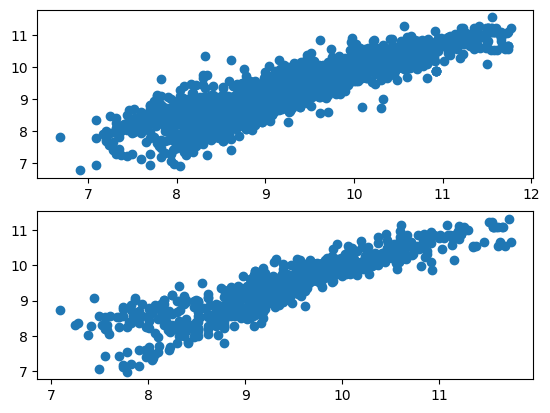

In [43]:
fig, ax = plt.subplots(2, sharex = False)

ax[0].scatter(y_train, y_hat)
ax[1].scatter(y_test, y_test_hat)

plt.show()

In [45]:
def execute_LR(x, y, test_size = 0.2, use_random_state = False, scaler = True, test_score = 0.8, tries = 100):
    iterations = 0
    scaler = StandardScaler()
    scaler.fit(x)
    x_scaled = scaler.transform(x)
    best_score = 0
    best_state = 0
    while iterations < tries:
        if use_random_state == True:
            random_state = np.random.randint(1000000)
        else:
            random_state = 365
        x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size = test_size, random_state = random_state)
        reg = LinearRegression()
        reg.fit(x_train, y_train)
        y_train_hat = reg.predict(x_train)
        y_train_hat = y_train_hat**math.e
        y_test_hat = reg.predict(x_test)
        y_test_hat = y_test_hat**math.e        
        train_diff = ((y_train_hat - y_train)**2).apply(math.sqrt).sum()
        test_diff = ((y_test_hat - y_test)**2).apply(math.sqrt).sum()
        if reg.score(x_test, y_test) >= test_score:
            iterations = tries
            best_score = reg.score(x_test, y_test)
            best_state = random_state
            print(f"Foi obtido um resultado de {best_score}")
            print(f"Utilizando o estado: {best_state}")
            print(f"Train diff: {train_diff}")
            print(f"Test diff: {test_diff}")
            return x_train, x_test, y_train, y_test, reg
            break
        else:
            iterations += 1
            if reg.score(x_test, y_test) > best_score:
                best_score = reg.score(x_test, y_test)
                best_state = random_state
    print(f"Não foi possível obter o resultado desejado. O melhor score encontrado foi: {best_score}")
    print(f"O melhor estado usado foi: {best_state}")
    print(f"Train diff: {train_diff}")
    print(f"Test diff: {test_diff}")
    return x_train, x_test, y_train, y_test, reg

In [ ]:
def show_residuals(reg, x, y):
    y_hat = reg.predict(x)
    plt.scatter(y, y_hat)
    plt.show()
    sns.displot(y, y_hat)

In [47]:
new_x_train, new_x_test, new_y_train, new_y_test, new_reg = execute_LR(df_preprocessed.drop(["log_price"], axis = 1), 
                                                                       df_preprocessed.log_price, use_random_state = True, tries = 1000, test_score = 0.9)

Não foi possível obter o resultado desejado. O melhor score encontrado foi: 0.8446914780979211
O melhor estado usado foi: 976870
Train diff: 1368077.246325772
Test diff: 341350.0292528863
